## Setup Environment and Install Dependencies

In [1]:
!pip install git+https://github.com/facebookresearch/segment-anything.git
!pip install -q supervision

import os
HOME = os.getcwd()
print("HOME:", HOME)

!mkdir -p {HOME}/weights
!wget -q -P {HOME}/weights https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

!mkdir -p {HOME}/data

!wget -q -P {HOME}/data https://media.roboflow.com/kitchen.jpg

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-40uyzgdy
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-40uyzgdy
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
HOME: /content
/content/weights/sam_vit_h_4b8939.pth ; exist: True


## Generate masks with SAM

In [2]:
import os
import cv2
import torch
import numpy as np
import supervision as sv

from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)
mask_generator = SamAutomaticMaskGenerator(sam)

SupervisionWarnings: white is deprecated: `Color.white()` is deprecated and will be removed in `supervision-0.22.0`. Use `Color.WHITE` instead.
SupervisionWarnings: black is deprecated: `Color.black()` is deprecated and will be removed in `supervision-0.22.0`. Use `Color.BLACK` instead.


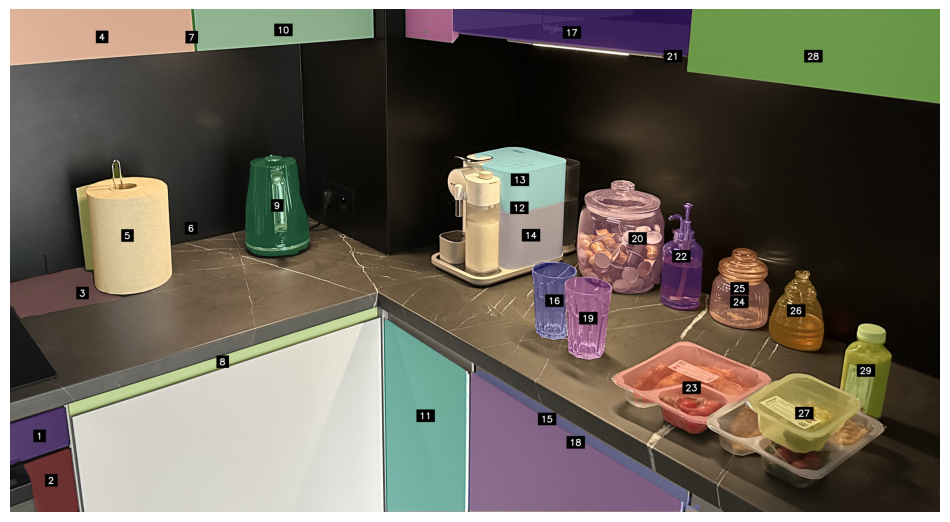

In [6]:
IMAGE_PATH = os.path.join(HOME, "data", "kitchen.jpg")
MIN_AREA_PERCENTAGE = 0.005
MAX_AREA_PERCENTAGE = 0.05

# load image
image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

# segment image
sam_result = mask_generator.generate(image_rgb)
detections = sv.Detections.from_sam(sam_result=sam_result)

# filter masks
height, width, channels = image_bgr.shape
image_area = height * width

min_area_mask = (detections.area / image_area) > MIN_AREA_PERCENTAGE
max_area_mask = (detections.area / image_area) < MAX_AREA_PERCENTAGE
detections = detections[min_area_mask & max_area_mask]

# print(detections)
# Calculate centroids of the masks
def calculate_centroid(xyxy):
    x1, y1, x2, y2 = xyxy
    centroid_x = (x1 + x2) // 2
    centroid_y = (y1 + y2) // 2
    return centroid_x, centroid_y

centroids = np.array([calculate_centroid(xyxy) for xyxy in detections.xyxy])
sorted_indices = np.lexsort((centroids[:, 1], centroids[:, 0]))
detections.xyxy = detections.xyxy[sorted_indices]
detections.mask = detections.mask[sorted_indices]


# setup annotators
mask_annotator = sv.MaskAnnotator(
    color_lookup=sv.ColorLookup.INDEX,
    opacity=0.3
)
label_annotator = sv.LabelAnnotator(
    color_lookup=sv.ColorLookup.INDEX,
    text_position=sv.Position.CENTER,
    text_scale=1,
    text_color=sv.Color.white(),
    color=sv.Color.black(),
    text_thickness=2
)

# annotate
labels = [str(i + 1) for i in range(len(detections))]

annotated_image = mask_annotator.annotate(
    scene=image_bgr.copy(), detections=detections)
annotated_image = label_annotator.annotate(
    scene=annotated_image, detections=detections, labels=labels)

sv.plot_image(annotated_image)